In [26]:
from rdkit import Chem
from rdkit.Chem import MolToSmiles

reader1 = Chem.SmilesMolSupplier("../compounds_to_test/LOTUS_DB.smi", delimiter="\t")
mols = [mol for mol in reader1]
ids = [mol.GetProp("_Name") for mol in mols]
smiles=[MolToSmiles(mol) for mol in mols]

In [1]:
import pandas as pd
pd.read_csv("../predictions_LOTUSDB/LOTUSDB_predictions.csv").shape

(276517, 3)

In [2]:
import pandas as pd

predictions_plants = pd.read_csv("../predictions_LOTUSDB/LOTUSDB_predictions_plants.csv")
smiles = predictions_plants.SMILES
ids = predictions_plants.ID

In [3]:
predictions_plants.shape

(190273, 3)

In [2]:
from deepmol.pipeline import Pipeline

best_pipeline = Pipeline.load("pipelines/sm_predictor_pipeline_tpe/trial_289")

2023-09-12 15:32:27.902759: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 15:32:28.635002: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


In [3]:
from tqdm import tqdm
bar = tqdm(total=len(smiles))

import numpy as np
from deepmol.datasets import SmilesDataset

predictions = []
last_i = 0

import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog('rdApp.error')

for i in range(10000, len(smiles), 10000):
    lotus_dataset = SmilesDataset(smiles=smiles[last_i:i], ids=ids[last_i:i])
    prediction = best_pipeline.predict(lotus_dataset)
    if i == 10000:
        predictions = prediction
    else:
        predictions = np.concatenate((predictions, prediction))

    last_i += 10000
    bar.update(10000)


lotus_dataset = SmilesDataset(smiles=smiles[last_i:], ids=ids[last_i:])
prediction = best_pipeline.predict(lotus_dataset)
predictions = np.concatenate((predictions, prediction))

100%|█████████▉| 190000/190273 [04:06<00:00, 760.63it/s]

In [4]:
predictions.shape

(190273, 20)

In [5]:
def convert_predictions_into_names(predictions):
    import numpy as np
    labels = np.array(['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341',
                                           'C00353', 'C00448', 'C01789', 'C03506',
                                           'C00047', 'C00108', 'C00187', 'C00148', 'C00041',
                                           'C00129', 'C00062', 'C01852', 'C00049', 'C00135'])
    
    labels_ = {
        'C00341': 'Geranyl diphosphate',
        'C01789': 'Campesterol',
        'C00078': 'Tryptophan',
        'C00049': 'L-Aspartate',
        'C00183': 'L-Valine',
        'C03506': 'Indoleglycerol phosphate',
        'C00187': 'Cholesterol',
        'C00079': 'L-Phenylalanine',
        'C00047': 'L-Lysine',
        'C01852': 'Secologanin',
        'C00407': 'L-Isoleucine',
        'C00129': 'Isopentenyl diphosphate',
        'C00235': 'Dimethylallyl diphosphate',
        'C00062': 'L-Arginine',
        'C00353': 'Geranylgeranyl diphosphate',
        'C00148': 'L-Proline',
        'C00073': 'L-Methionine',
        'C00108': 'Anthranilate',
        'C00123': 'L-Leucine',
        'C00135': 'L-Histidine',
        'C00448': 'Farnesyl diphosphate',
        'C00082': 'L-Tyrosine',
        'C00041': 'L-Alanine'
    }
    
    labels_names = np.array([labels_[label] for label in labels])
    ones = predictions == 1
    labels_all = []
    for i, prediction in enumerate(ones):
        labels_all.append(";".join(labels_names[prediction]))
    return labels_all

In [7]:
import pandas as pd
labels_all = convert_predictions_into_names(predictions)
df = pd.DataFrame({"ID": ids, "SMILES": smiles, "Predicted Precursors": labels_all})

In [8]:
df.to_csv("../predictions_LOTUSDB/LOTUSDB_predictions_plants_final_version.csv", index=False)

## Let's see how many compounds have been predicted to be produced from each precursor

In [38]:
import pandas as pd

lotus_db_predictions = pd.read_csv("../predictions_LOTUSDB/LOTUSDB_predictions.csv")

In [1]:
import json 

with open("../predictions_LOTUSDB/lotus.json", "r") as f:
    lotus_db = json.load(f)

In [43]:
lotus_db["LTS0116501"]

{'taxonomy': {'10$x$x$1021/JA01255A031': {'ITIS': [{'cleaned_organism_id': '524919',
     'organism_value': 'Crotalaria virgulata subsp. grantiana',
     'kingdom': 'Plantae',
     'classx': 'Magnoliopsida',
     'family': 'Fabaceae',
     'genus': 'Crotalaria',
     'species': 'Crotalaria virgulata'}],
   'NCBI': [{'cleaned_organism_id': '165768',
     'organism_value': 'Crotalaria virgulata subsp. grantiana',
     'superkingdom': 'Eukaryota',
     'kingdom': 'Viridiplantae',
     'phylum': 'Streptophyta',
     'classx': 'Magnoliopsida',
     'family': 'Fabaceae',
     'genus': 'Crotalaria',
     'species': 'Crotalaria virgulata'}],
   'Open Tree of Life': [{'cleaned_organism_id': '752739',
     'organism_value': 'Crotalaria virgulata subsp. grantiana',
     'domain': 'Eukaryota',
     'kingdom': 'Archaeplastida',
     'phylum': 'Streptophyta',
     'classx': 'Magnoliopsida',
     'family': 'Fabaceae',
     'genus': 'Crotalaria',
     'species': 'Crotalaria virgulata'}],
   'GBIF Back

In [35]:
filtered_for_plants = []
for compound in lotus_db:
    only_key = list(lotus_db[compound]["taxonomy"].keys())[0]
    if "GBIF Backbone Taxonomy" in lotus_db[compound]["taxonomy"][only_key]:
        taxonomies = lotus_db[compound]["taxonomy"][only_key]["GBIF Backbone Taxonomy"]
        for taxonomy in taxonomies:
            if "kingdom" not in taxonomy:
                pass
            else:
                if taxonomy["kingdom"] == "Plantae":
                    filtered_for_plants.append(compound)
    
    elif "NCBI" in lotus_db[compound]["taxonomy"][only_key]:
        taxonomies = lotus_db[compound]["taxonomy"][only_key]["NCBI"]
        for taxonomy in taxonomies:
            if "kingdom" not in taxonomy:
                pass
            else:
                if taxonomy["kingdom"] == "Viridiplantae":
                    filtered_for_plants.append(compound)
    elif "ITIS" in lotus_db[compound]["taxonomy"][only_key]:
        taxonomies = lotus_db[compound]["taxonomy"][only_key]["ITIS"]
        for taxonomy in taxonomies:
            if "kingdom" not in taxonomy:
                pass
            else:
                if taxonomy["kingdom"] == "Plantae":
                    filtered_for_plants.append(compound)
    elif "Open Tree of Life" in lotus_db[compound]["taxonomy"][only_key]:
        taxonomies = lotus_db[compound]["taxonomy"][only_key]["Open Tree of Life"]
        for taxonomy in taxonomies:
            if "phylum" not in taxonomy:
                pass
            else:
                if taxonomy["phylum"] == "Streptophyta":
                    filtered_for_plants.append(compound)
    elif "iNaturalist" in lotus_db[compound]["taxonomy"][only_key]:
        taxonomies = lotus_db[compound]["taxonomy"][only_key]["iNaturalist"]
        for taxonomy in taxonomies:
            if "kingdom" not in taxonomy:
                pass
            else:
                if taxonomy["kingdom"] == "Plantae":
                    filtered_for_plants.append(compound)
        


In [37]:
len(filtered_for_plants)

219719

In [41]:
lotus_db_predictions_plants = lotus_db_predictions[lotus_db_predictions["ID"].isin(filtered_for_plants)]
lotus_db_predictions_plants.to_csv("../predictions_LOTUSDB/LOTUSDB_predictions_plants.csv", index=False)
lotus_db_predictions_plants.shape

(190273, 3)

In [2]:
import pandas as pd
lotus_db_predictions_plants = pd.read_csv("../predictions_LOTUSDB/LOTUSDB_predictions_plants_final_version.csv")

In [3]:
lotus_db_predictions_plants.set_index("ID", inplace=True)
for i, compound in lotus_db_predictions_plants.iterrows():
    chemical_ontology = lotus_db[i]["chemical_ontology"]
    if "chemicalTaxonomyNPclassifierPathway" in chemical_ontology:
        pathway = chemical_ontology["chemicalTaxonomyNPclassifierPathway"]
        lotus_db_predictions_plants.loc[i, "Pathway"] = pathway
    if "chemicalTaxonomyNPclassifierSuperclass" in chemical_ontology:
        superclass = chemical_ontology["chemicalTaxonomyNPclassifierSuperclass"]
        lotus_db_predictions_plants.loc[i, "Superclass"] = superclass
    if "chemicalTaxonomyNPclassifierClass" in chemical_ontology:
        class_ = chemical_ontology["chemicalTaxonomyNPclassifierClass"]
        lotus_db_predictions_plants.loc[i, "Class"] = class_

In [4]:
lotus_db_predictions_plants

,SMILES,Predicted Precursors,Pathway,Superclass,Class
ID,,,,,
LTS0124597,CC(=O)OC1C(OC2C(OC3CC(O)CC4=CCC5C6CC7OC8(CCC(C...,Cholesterol,NaN,NaN,NaN
LTS0121510,C[C@H](CO)[C@H]1OC(=O)C=C2C1=C[C@H]1OC(=O)[C@]...,NaN,Terpenoids,Diterpenoids,Nagilactone diterpenoids
LTS0110032,CS(=O)(=O)C=CCO,NaN,Fatty acids,Fatty acyls,Fatty alcohols
LTS0116501,CC1C(=O)OC2(C)C1C(=O)OC1CCN3CC=C(COC(=O)C2(C)O...,Geranylgeranyl diphosphate,Alkaloids,Ornithine alkaloids,Pyrrolizidine alkaloids
LTS0256634,CC1=CC(=O)[C@H](O)[C@@]2(C)C[C@H]3OC(=O)C(C)=C...,NaN,Terpenoids,Sesquiterpenoids,Eudesmane sesquiterpenoids
...,...,...,...,...,...
LTS0200952,O=C(OCC1=C[C@@H](O)[C@H]2C=CO[C@H](O[C@@H]3O[C...,Geranyl diphosphate,Terpenoids,Monoterpenoids,Iridoids monoterpenoids
LTS0059294,C=C1C[C@@H]2OC(=O)[C@H](C)[C@H]2[C@@H](O)/C=C(...,Farnesyl diphosphate,Terpenoids,Sesquiterpenoids,Germacrane sesquiterpenoids
LTS0083019,COC(=O)C1=CO[C@@H](O[C@@H]2O[C@H](CO)[C@@H](O)...,Geranyl diphosphate,Terpenoids,Monoterpenoids,Iridoids monoterpenoids


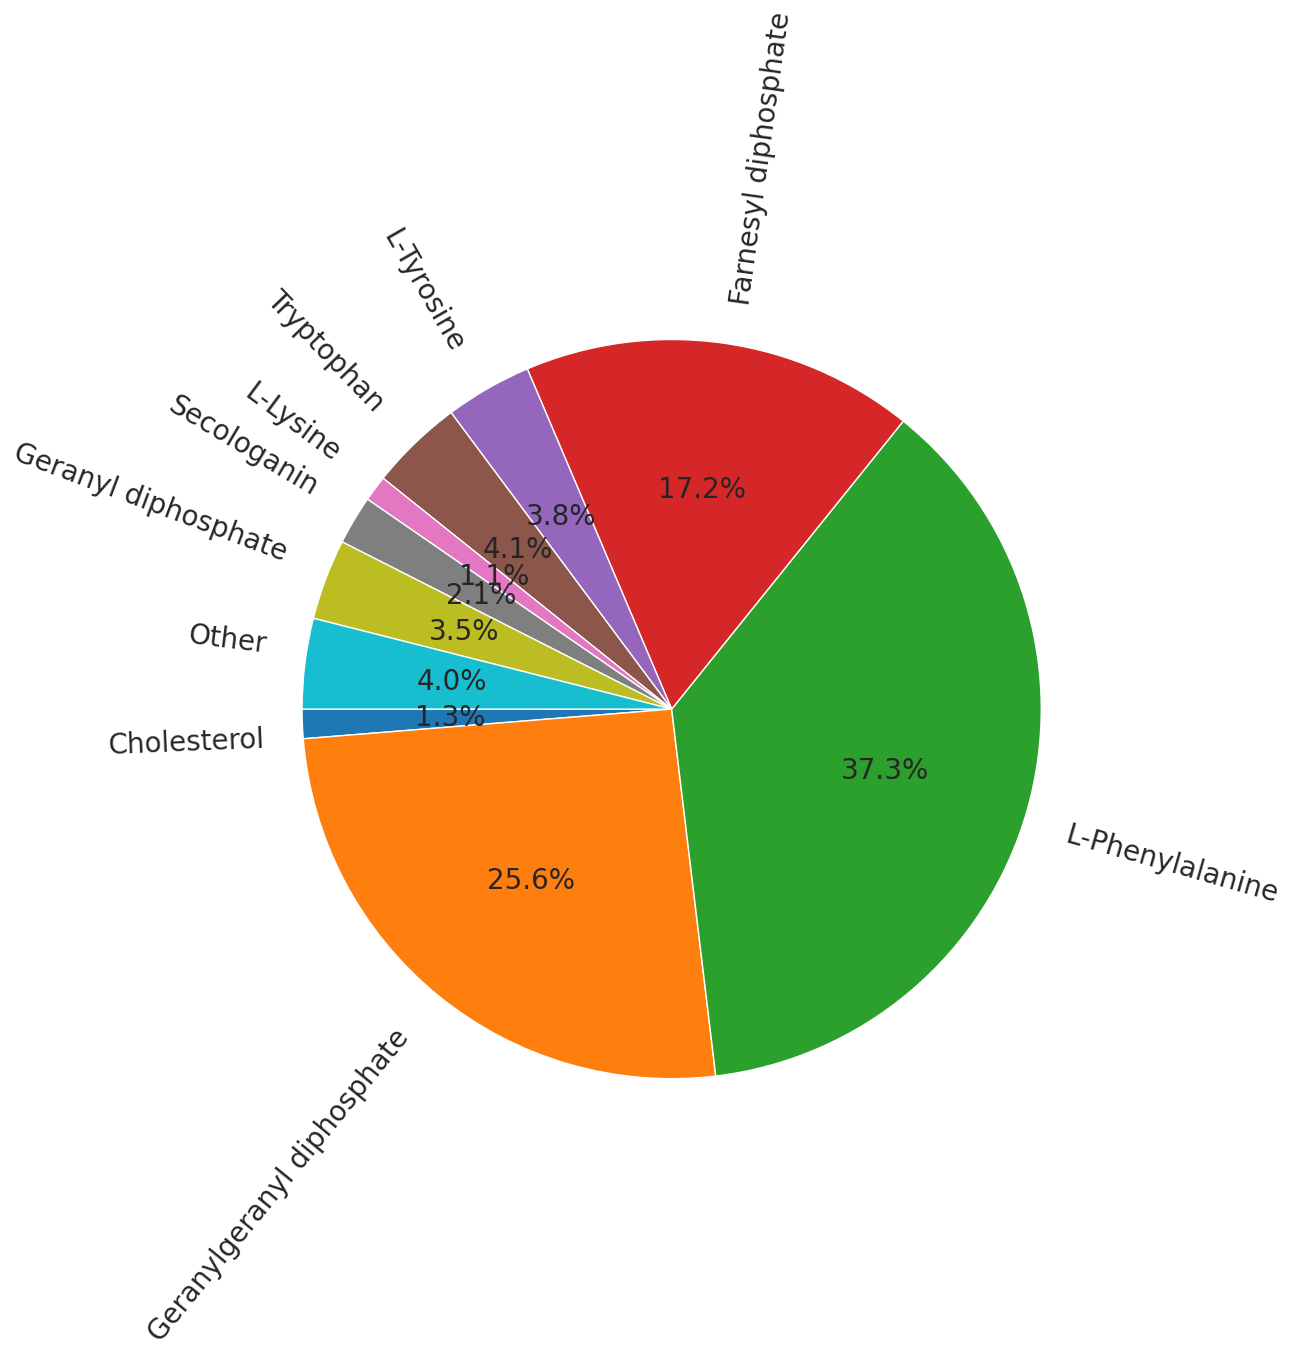

In [18]:
# make a pie chart of the predicted precursors
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

counts = {}
for i, compound in lotus_db_predictions_plants.iterrows():
    if pd.isna(compound["Predicted Precursors"]):
        if "None" not in counts:
            counts["No prediction"] = 1
        else:
            counts["No prediction"] += 1
    else:
        for label in compound["Predicted Precursors"].split(";"):
            if label not in counts:
                counts[label] = 1
            else:
                counts[label] += 1

# make a pie chart with these counts
labels = []
sizes = []
other = 0
for label in counts:
    if counts[label]/ sum(counts.values()) < 0.01:
        other += counts[label]
    else:
        labels.append(label)
        sizes.append(counts[label])

labels.append("Other")
sizes.append(other)
# only show the top 10
labels = labels[:10]
sizes = sizes[:10]

# make a pie chart
plt.figure(figsize=(15, 12))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=180, rotatelabels=True)

# increase the font size of the labels
for text in plt.gca().texts:
    text.set_fontsize(20)

In [68]:
# from the ones that are predicted phelylalanine get the ones that are terpenes
counts = {}
for i, compound in lotus_db_predictions_plants.iterrows():
    if not pd.isnull(compound["Predicted Precursors"]) and "L-Phenylalanine" in compound["Predicted Precursors"]:
        if not pd.isnull(compound["Pathway"]):
            if "Phenylpropanoids" in compound["Pathway"]:
                counts["Phenylpropanoids"] = counts.get("Phenylpropanoids", 0) + 1
            elif "Alkaloids" in compound["Pathway"]:
                counts["Alkaloids"] = counts.get("Alkaloids", 0) + 1
            elif "Terpenoids" in compound["Pathway"]:
                counts["Terpenoids"] = counts.get("Terpenoids", 0) + 1
            else:
                counts["Other"] = counts.get("Other", 0) + 1


In [71]:

def generate_bar_plot_for_comopunds(counts, pallete=sns.color_palette("YlOrBr")):
    # Calculate the total count
    total_count = sum(counts.values())
    
    # Calculate percentages
    percentages = {category: (count / total_count) * 100 for category, count in counts.items()}
    
    plt.rc('font', size=14) 
    # Bar plot
    plt.bar(percentages.keys(), percentages.values(),color=pallete)
    plt.xlabel("Categories")
    plt.ylabel("Percentage")
    plt.ylim(0, 100, 10)
    plt.title("Percentage of Counts for Different Categories", pad=30)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    
    # Show the plot
    plt.show()

/tmp/ipykernel_9131/3735614143.py:13: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0, 100, 10)


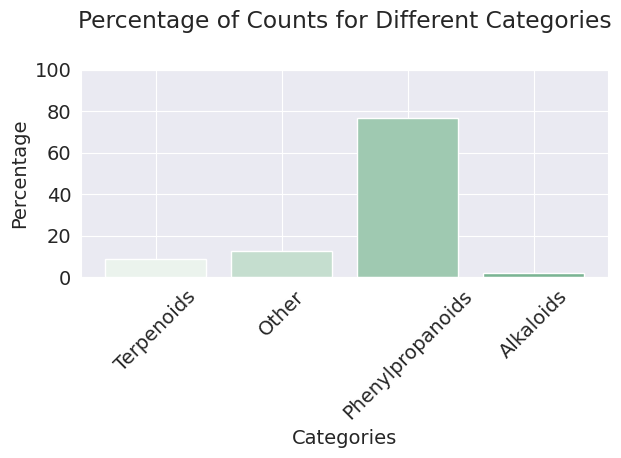

In [75]:
generate_bar_plot_for_comopunds(counts, pallete=sns.light_palette("seagreen"))

In [76]:
# from the ones that are predicted phelylalanine get the ones that are terpenes
counts = {}
for i, compound in lotus_db_predictions_plants.iterrows():
    if not pd.isnull(compound["Predicted Precursors"]) and "Geranylgeranyl diphosphate" in compound["Predicted Precursors"]:
        if not pd.isnull(compound["Superclass"]):
            if "diterpenoid" in compound["Superclass"].lower():
                counts["Diterpenoids"] = counts.get("Diterpenoids", 0) + 1
            elif "carotenoids" in compound["Superclass"].lower():
                counts["Carotenoids"] = counts.get("Carotenoids", 0) + 1
            elif "terpenoid" in compound["Superclass"].lower():
                counts["Other terpenoids"] = counts.get("Other terpenoids", 0) + 1
            else:
                counts["Other"] = counts.get("Other", 0) + 1


/tmp/ipykernel_9131/3735614143.py:13: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0, 100, 10)


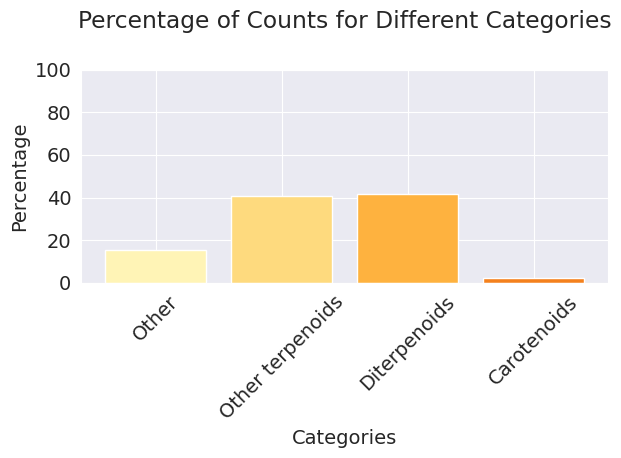

In [77]:
generate_bar_plot_for_comopunds(counts)

In [78]:
counts = {}
for i, compound in lotus_db_predictions_plants.iterrows():
    if not pd.isnull(compound["Predicted Precursors"]) and "Farnesyl diphosphate" in compound["Predicted Precursors"]:
        if not pd.isnull(compound["Superclass"]):
            if "triterpenoid" in compound["Superclass"].lower():
                counts["Triterpenoids"] = counts.get("Triterpenoids", 0) + 1
            elif "sesquiterpenoid" in compound["Superclass"].lower():
                counts["Sesquiterpenoid"] = counts.get("Sesquiterpenoid", 0) + 1
            elif "terpenoid" in compound["Superclass"].lower():
                counts["Other terpenoids"] = counts.get("Other terpenoids", 0) + 1
            else:
                counts["Other"] = counts.get("Other", 0) + 1

/tmp/ipykernel_9131/3735614143.py:13: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0, 100, 10)


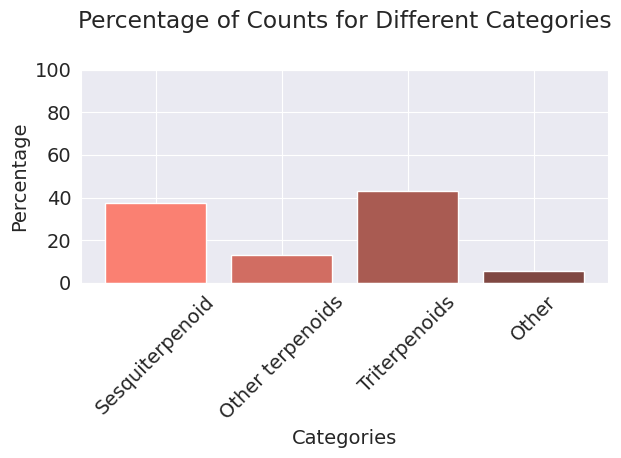

In [79]:
generate_bar_plot_for_comopunds(counts, sns.color_palette("dark:salmon_r"))

In [80]:
sns.color_palette("dark:salmon_r")

[(0.9803921568627451, 0.5019607843137255, 0.4470588235294118),
 (0.8206223693544625, 0.42905134566038194, 0.3844558865578708),
 (0.6608525818461801, 0.35614190700703835, 0.3218529495863298),
 (0.5010827943378977, 0.2832324683536948, 0.25925001261478886),
 (0.3413130068296151, 0.21032302970035122, 0.19664707564324785),
 (0.18154321932133266, 0.1374135910470077, 0.13404413867170692)]

# Analysis of case studies

## Case study 1 - tomato

In [5]:
from deepmol.loaders import CSVLoader

tomato_dataset = CSVLoader("case_studies/tomato.csv", smiles_field="smiles", id_field="id").create_dataset()

In [32]:
from deepmol.pipeline import Pipeline

best_pipeline = Pipeline.load("pipelines/sm_predictor_pipeline_tpe/trial_289")

In [33]:
predictions = best_pipeline.predict(tomato_dataset)

In [34]:
convert_predictions_into_names(predictions)

['Tryptophan',
 'Geranylgeranyl diphosphate',
 'Geranylgeranyl diphosphate',
 'Cholesterol',
 'Cholesterol',
 'Cholesterol']

## Analyse the similarity

### Similarity between the predicted and the real compounds - tomato glycoalkaloids 

In [6]:
from PIL import Image
import io
from rdkit.Chem.Draw import SimilarityMaps

def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

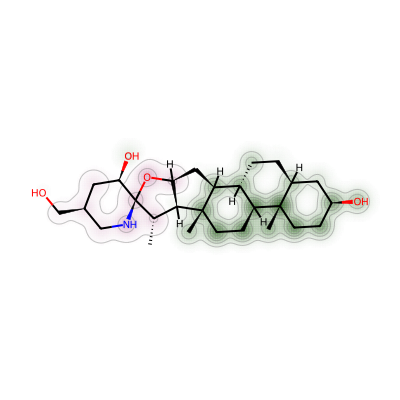

In [7]:
from rdkit.Chem import MolFromSmiles
from rdkit import Chem

d = Chem.Draw.MolDraw2DCairo(400, 400)
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(MolFromSmiles("C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C"), tomato_dataset.mols[3], lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                        draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

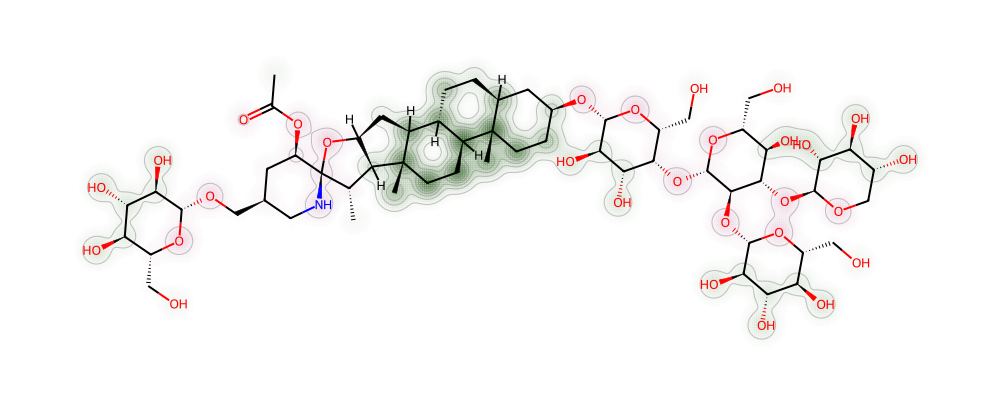

In [80]:
from rdkit.Chem import MolFromSmiles
from rdkit import Chem

d = Chem.Draw.MolDraw2DCairo(1000, 400)
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(MolFromSmiles("C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C"), tomato_dataset.mols[4], lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                        draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

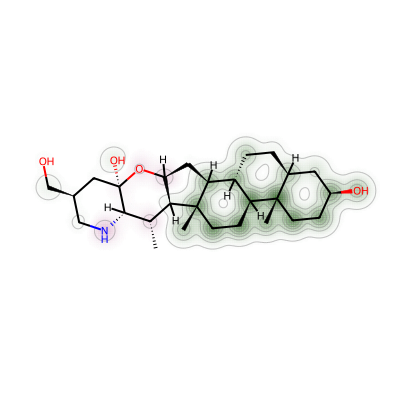

In [75]:
from rdkit.Chem import MolFromSmiles
from rdkit import Chem

d = Chem.Draw.MolDraw2DCairo(400, 400)
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(MolFromSmiles("C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C"), tomato_dataset.mols[5], lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                        draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

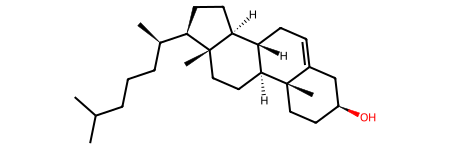

In [11]:
MolFromSmiles("C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C")

### Similarity between the predicted and the real compounds - tomato compounds

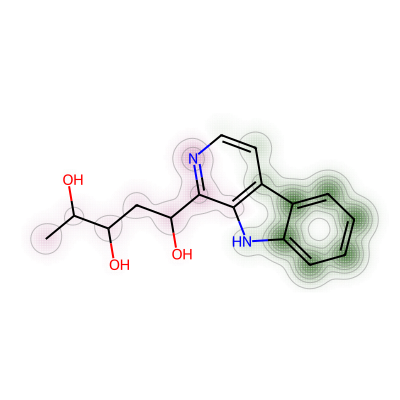

In [8]:
from rdkit.Chem import MolFromSmiles
from rdkit import Chem



d = Chem.Draw.MolDraw2DCairo(400, 400)
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(MolFromSmiles("C1=CC=C2C(=C1)C(=CN2)C[C@@H](C(=O)O)N"), tomato_dataset.mols[0], lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                        draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

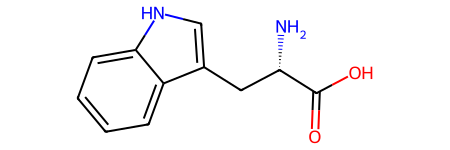

In [9]:
MolFromSmiles("C1=CC=C2C(=C1)C(=CN2)C[C@@H](C(=O)O)N")

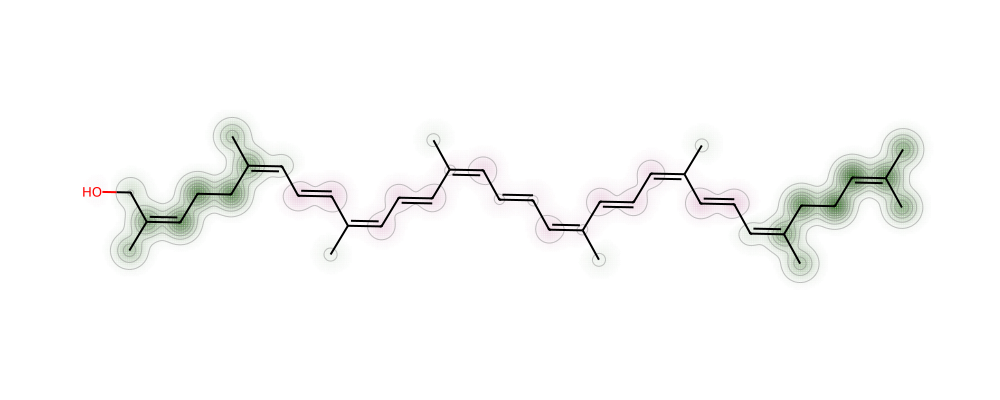

In [7]:
from rdkit.Chem import MolFromSmiles
from rdkit import Chem



d = Chem.Draw.MolDraw2DCairo(1000, 400)
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(MolFromSmiles("CC(=CCC/C(=C/CC/C(=C/CC/C(=C/COP(=O)(O)OP(=O)(O)O)/C)/C)/C)C"), tomato_dataset.mols[1], lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                        draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

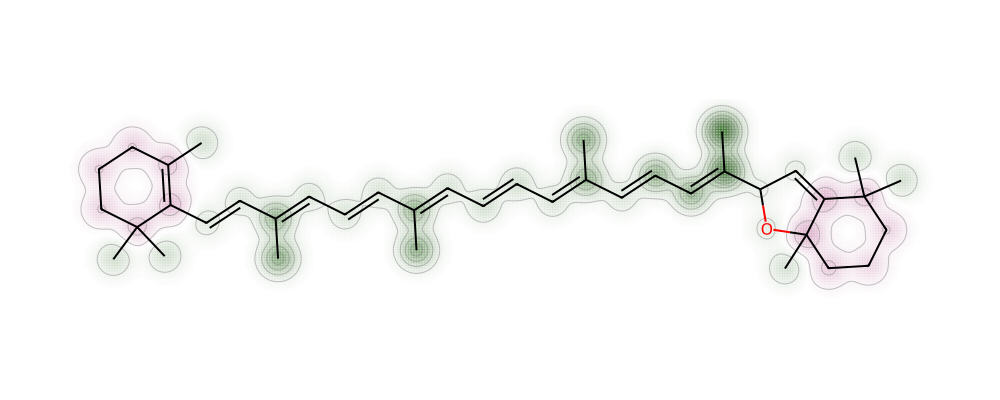

In [8]:
from rdkit.Chem import MolFromSmiles
from rdkit import Chem



d = Chem.Draw.MolDraw2DCairo(1000, 400)
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(MolFromSmiles("CC(=CCC/C(=C/CC/C(=C/CC/C(=C/COP(=O)(O)OP(=O)(O)O)/C)/C)/C)C"), tomato_dataset.mols[2], lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                        draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

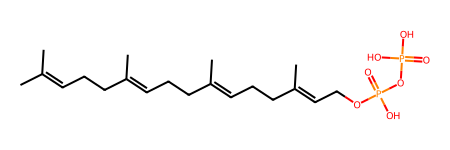

In [10]:
MolFromSmiles("CC(=CCC/C(=C/CC/C(=C/CC/C(=C/COP(=O)(O)OP(=O)(O)O)/C)/C)/C)C")